In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append('../../code')
import visualize
from crispr import CasTemplate
from pipeline import NDNFPipeline

# Parameters

Here well define a set of parameters that can be changed to adjust the standard analysis.

In [3]:
CAS = CasTemplate(pam_motif = 'TTTV', typ='V', 
                  protospacer_length=20, name='LbCas12a_Cpf1')

In [4]:
# Path to a collection of HIV sequences to use as the nomination set.
NOMINATE_FASTA = '../../data/nominate.fasta'

# Path to a collection of HIV sequences to use as the validation set.
VALIDATE_FASTA = '../../data/test.fasta'

# Path to a single HIV sequence to use as the common reference position set.
REFERENCE_FASTA = '../../data/hxb2.fasta'

# Path to an off-target reference genome.
OFFTARGET_REF = '../../data/GRCh38.fna'

# The number of protospacers to extract from the nomination set.
TOP_N_KMERS = 20_000

# The target number of protospacers after diversification.
DIVERSITY_TARGET = TOP_N_KMERS*2





# Nominate

First, we start with a wide collection of HIV full genomic sequences.
Each k-mer assocaited with a valid PAM is extracted by regular expression.
These k-mers are counted and the top TOP_N_KMERS are kept.

## Load nomination sequences

In [5]:
with open(NOMINATE_FASTA) as handle:
    nomination_seqs = list(SeqIO.parse(handle, 'fasta'))
num_nom = len(nomination_seqs)
len_nom = sum(len(seqR.seq) for seqR in nomination_seqs)/1_000_000
print(f'Loading {num_nom} sequences with a total of {len_nom:0.2f} Mbp for nomination.')

Loading 3228 sequences with a total of 28.73 Mbp for nomination.


## Nominate

In [6]:
nominated, protospacer_counts = NDNFPipeline.nominate(CAS, nomination_seqs, 
                                                      top_n=TOP_N_KMERS, 
                                                      return_counts=True)

100%|██████████| 3228/3228 [00:15<00:00, 205.07it/s]


# Diversify

Next, we divesify the top protospacers.
This is done by randomly picking gRNAs and randomly mutating them.
This introduces diversity that was not present in the initial population.

In [7]:
diversed = nominated.diversify(DIVERSITY_TARGET)

100%|██████████| 40000/40000 [07:39<00:00, 87.01it/s]    


# Narrow

With this pool of protospacers, we can evaluate which are the most effective on the held-out set.

In [8]:
narrowed, protospacer_hist_freq = diversed.narrow(VALIDATE_FASTA, min_rate=0.1, 
                                                  mismatch = 2, 
                                                  return_freqs=True)

Total 1 device(s) found.
Loading input file...
Reading ../../data/test.fasta...
Sending data to devices...
Chunk load started.
1 devices selected to analyze...
Finding pattern in chunk #1...
Comparing patterns in chunk #1...
106.15 seconds elapsed.


# Filter

Using the narrowed hits, we now need to search for protospacers without targets in the human genome.


In [9]:
good_hits, off_target_counts = narrowed.filter(OFFTARGET_REF,
                                               mismatch = 2, 
                                               return_counts=True)

Total 1 device(s) found.
Loading input file...
Reading ../../data/GRCh38.fna...
Sending data to devices...
Chunk load started.
1 devices selected to analyze...
Finding pattern in chunk #1...
Comparing patterns in chunk #1...
1 devices selected to analyze...
Finding pattern in chunk #2...
Comparing patterns in chunk #2...
320.207 seconds elapsed.


# Protospacer evaluation

In [10]:
ref_diversed = diversed.reference_map(REFERENCE_FASTA, mismatch=3, enforce_pam=False)

Total 1 device(s) found.
Loading input file...
Reading ../../data/hxb2.fasta...
Sending data to devices...
Chunk load started.
1 devices selected to analyze...
Finding pattern in chunk #1...
Comparing patterns in chunk #1...
47.8714 seconds elapsed.


In [11]:
ref_diversed['on_target_freq'] = ref_diversed['protospacer'].map(protospacer_hist_freq.get)
ref_diversed['off_target_hits'] = ref_diversed['protospacer'].map(off_target_counts.get)

In [12]:
MUT_DATA = pd.read_csv('../../data/mutation_scores.csv')

def rc_scores(start, width=20):
    
    mask = (MUT_DATA['Position'] <= (start+width)) & (MUT_DATA['Position'] >= (start-width))
    mean_rc = MUT_DATA.loc[mask, 'RC Index'].mean()
    
    return mean_rc

def lethal_count(start, width=20):
    
    mask = (MUT_DATA['Position'] <= (start+width)) & (MUT_DATA['Position'] >= (start-width))
    num_lethal = (MUT_DATA.loc[mask, 'Effect'] == "lethal").sum()
    
    return num_lethal

    
    

In [13]:
ref_diversed['num_lethal'] = ref_diversed['start'].map(lethal_count)
ref_diversed['mean_rc'] = ref_diversed['start'].map(rc_scores)

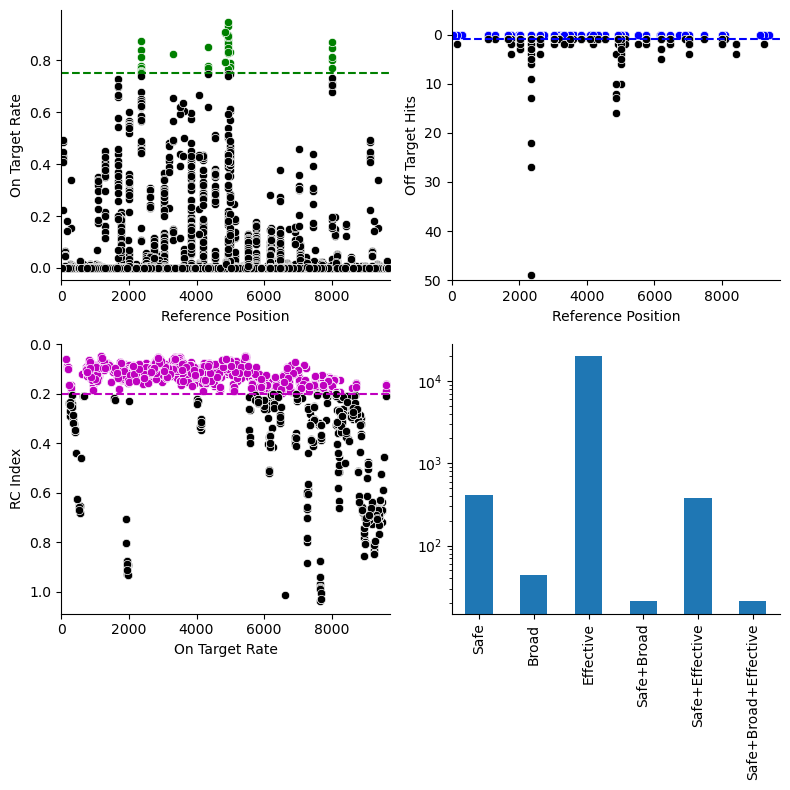

In [14]:
fig, ((on_loc_ax, off_loc_ax), (on_rc_ax, sum_ax)) = plt.subplots(2, 2, figsize=(8, 8))


sns.scatterplot(data = ref_diversed.query('on_target_freq>=0.75'),
                x = 'start', y = 'on_target_freq',
                ax=on_loc_ax, color = 'g')
sns.scatterplot(data = ref_diversed.query('on_target_freq<0.75'),
                x = 'start', y = 'on_target_freq',
                ax=on_loc_ax, color = 'k')
on_loc_ax.set_ylabel('On Target Rate')
on_loc_ax.set_xlabel('Reference Position')
on_loc_ax.set_xlim(0, 9717)

on_loc_ax.axhline(0.75, color = 'g', linestyle = '--')

sns.despine(ax=on_loc_ax)

sns.scatterplot(data = ref_diversed.query("off_target_hits==0"),
                x = 'start', y = 'off_target_hits',
                ax=off_loc_ax, color = 'b')
sns.scatterplot(data = ref_diversed.query("off_target_hits>0"),
                x = 'start', y = 'off_target_hits',
                ax=off_loc_ax, color = 'k')


off_loc_ax.set_ylim(50, -5)
off_loc_ax.set_ylabel('Off Target Hits')
off_loc_ax.set_xlabel('Reference Position')
off_loc_ax.axhline(1, color = 'b', linestyle = '--')
sns.despine(ax=off_loc_ax)
off_loc_ax.set_xlim(0, 9717)

sns.scatterplot(data = ref_diversed.query("mean_rc<0.2"),
                     x = 'start', y = 'mean_rc',
                     ax=on_rc_ax, color = 'm')

sns.scatterplot(data = ref_diversed.query("mean_rc>0.2"),
                     x = 'start', y = 'mean_rc',
                     ax=on_rc_ax, color = 'k')

on_rc_ax.set_xlabel('On Target Rate')
on_rc_ax.set_ylabel('RC Index')

#on_rc_ax.axhline(0.9, color = 'g', linestyle = '--')
on_rc_ax.axhline(0.2, color = 'm', linestyle = '--')

on_rc_ax.set_ylim(on_rc_ax.get_ylim()[1], on_rc_ax.get_ylim()[0])
on_rc_ax.set_xlim(0, 9717)

sns.despine(ax=on_rc_ax)

safe = (ref_diversed['off_target_hits'] == 0)
broad = (ref_diversed['on_target_freq'] >= 0.75)
effective = (ref_diversed['mean_rc'] <= 0.2)

summary = pd.Series({'Safe': safe.sum(),
                     'Broad': broad.sum(),
                     'Effective': effective.sum(),
                     'Safe+Broad': (safe&broad).sum(),
                     'Safe+Effective': (safe&effective).sum(),
                     'Safe+Broad+Effective': (safe&effective&broad).sum()})

summary.plot(kind='bar', ax=sum_ax)
sum_ax.set_yscale('log')
sns.despine(ax=sum_ax)

fig.tight_layout()
fig.savefig(CAS.name + '.png', dpi=300)

In [15]:
keys, order = ['off_target_hits', 'on_target_freq', 'mean_rc'], [True, False, True]

ref_diversed.sort_values(keys, ascending = order).to_csv(CAS.name + '.csv', index=False)